In [0]:
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
#hosted on colab

In [2]:
x=np.array([12,123,32,5,4,3,5,67])
y=np.array([11,133,22,5,2,1,5,44])
pearsonr(x,y) #returns (corr,p-value of the 2 tailed test)

(0.9771274513188724, 2.9403813332491067e-05)

In [0]:
#function that returns rolling correlations
def roll_corr(x,y,length=5):
  corr=[]
  x_len=len(x)
  if (x_len!=len(y)):
    print("length of dataset do not match")
    return
  if (length>x_len):
    print("length of rolling window exceeds data")
    return
  for i in range(x_len):
    if (i+length>=x_len):
      break
    temp=pearsonr(x[i:i+length],y[i:i+length])[0]
    corr.append(temp)
  return corr

In [4]:
#example of above function
roll_corr(x,y,4)

[0.9953771854549682,
 0.9956629841931625,
 0.9929078162734514,
 0.9710607611177228]

In [0]:
class data_environment(object):
  def __init__(self,url_list):
    self.init_data(url_list) 
    self.preprocess_data()

  def init_data(self,url_list): #initialise data
    self.raw_data=[]
    for url in url_list:
      self.raw_data.append(pd.read_csv(url))  

  def get_daily_price(self,data): #gets average of High and Low
    return data.loc[:,['High','Low']].mean(axis=1).values

  def get_logr(self,data): #calculates 1 day log returns
    returns=data[1:]/data[:-1]
    return pd.Series(np.log(returns)).rename('Log-return')

  def get_datetime(self,data): #returns Date column as a datetime column
    date=pd.to_datetime(data.Date)
    return date     

  def preprocess_data(self): #run all preprocessing and cleaning
    self.data=[]
    for i in range(len(self.raw_data)):
      date=self.get_datetime(self.raw_data[i])
      logr=self.get_logr(self.get_daily_price(self.raw_data[i]))
      self.data.append(pd.concat([date,logr],axis=1))

In [0]:
sp500_link='https://raw.githubusercontent.com/huddyyeo/LSE_practitioners_challenge/master/Data/%5EGSPC.csv'
yields_link='https://raw.githubusercontent.com/huddyyeo/LSE_practitioners_challenge/master/Data/%5ETNX.csv'
test_url=[sp500_link,yields_link]
#creation of our data environment
data_env=data_environment(test_url)

In [10]:
#consolidating our data
df=pd.merge(data_env.data[0],data_env.data[1],on='Date',how='inner')
df=df.dropna()
df

,Date,Log-return_x,Log-return_y
0,1990-01-29,-0.005469,0.001176
1,1990-01-30,0.010018,-0.009445
2,1990-01-31,0.008491,-0.001187
3,1990-02-01,0.003900,0.009456
5,1990-02-05,-0.003856,0.004678
...,...,...,...
7547,2020-01-15,0.006149,0.005013
7548,2020-01-16,0.004343,0.018167
7550,2020-01-21,0.001715,-0.005347
7551,2020-01-22,-0.004374,-0.021966


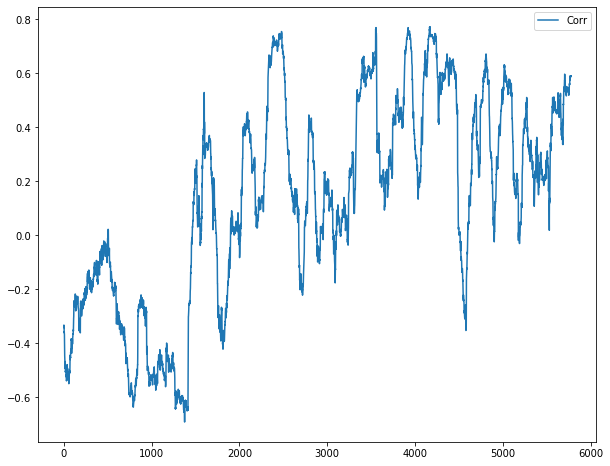

In [11]:
#plotting rolling correlations of 100 days or 20 weeks
corr_data=roll_corr(df.loc[:,'Log-return_x'].values,df.loc[:,'Log-return_y'].values,100)
plt.figure(figsize=[10,8])
plt.plot(corr_data,label="Corr")
plt.legend()
plt.show()

In [0]:
#run rolling correlation windows, from length 4 to 200(1 year)
#from the correlation data calculated, obtain first 4 central moments
from scipy.stats import skew
from scipy.stats import kurtosis
corr_data=pd.DataFrame(columns=['window_length','mean','var','skew','kurtosis'])
for i in range(4,201):
  values=roll_corr(df.loc[:,'Log-return_x'].values,df.loc[:,'Log-return_y'].values,i)
  entry_dict={'window_length':i,
              'mean':np.mean(values),
              'var':np.var(values),
              'skew':skew(values),
              'kurtosis':kurtosis(values)}
  corr_data=corr_data.append(entry_dict,ignore_index=True)
  print(i)

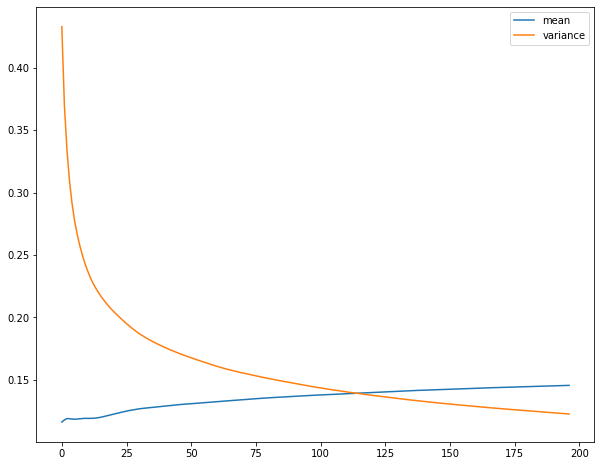

In [49]:
plt.figure(figsize=[10,8])
plt.plot(corr_data.loc[:,'mean'],label='mean')
plt.plot(corr_data.loc[:,'var'],label='variance')
plt.legend()
plt.show()

Can observe variance steadily decreasing, as expected

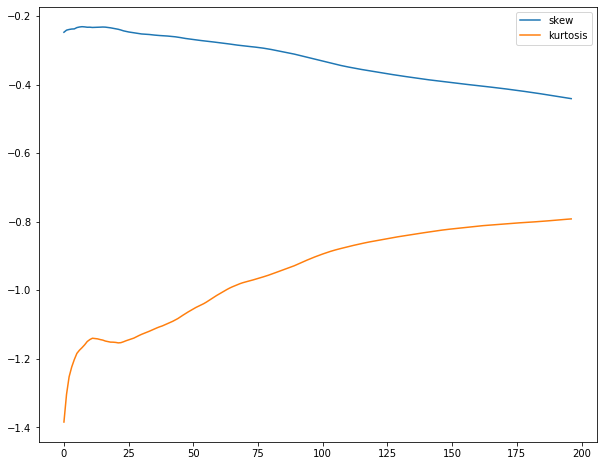

In [50]:
plt.figure(figsize=[10,8])
plt.plot(corr_data.loc[:,'skew'],label='skew')
plt.plot(corr_data.loc[:,'kurtosis'],label='kurtosis')
plt.legend()
plt.show()